#### Problem Statement:
##### You work for a payments orchestrator company, that enables seamless integration and management of multiple payment methods and gateways for businesses to optimize their payment processing.
##### On Feb 14, 2020, you get calls from many merchants. Merchants tell you that they are seeing a spike in customer complaints and want you to check if there are any issues. You tell them that you are going to revert to them in a few hours.

#### Data:
##### You have the payment transactions data for Feb 12, 13 and 14.
##### Below is a description of different columns in the data set
##### hr : Start hour of the transaction
##### mid : Merchant Identifier
##### t : Total number of transactions
##### success : Total number of `successful` transactions
##### pg : Payment Gateway, who collects money on behalf of the merchant
##### pmt : Payment Method Type such as cards, UPI etc.,
##### sub_type : The subtype of payment option chosen by the customer
##### bank : The customer bank account from which the money is sent

### My solution:

#### First, I am going to plot the data as a time series (Date-Hour in the X-axis and Rate of Payment Failures in the Y-axis)
#### Then I am going to observe the spikes individiually and on an aggregate basis.
#### Then, I will apply IsolationForest ML model for Anomaly Detection to understand which combination of features led to the highest rate of payment failures.
#### Then I will look into which merchants have been most affected by this issue on 14th Feb 2020.

In [1]:
#Importing the libraries
import pandas as pd # For data analysis
from sklearn.ensemble import IsolationForest # For anomaly detection
import matplotlib.pyplot as plt # For data visualization

# To suppress unnecessary warnings related to dependency versions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data
file_path = 'Transactions_modified.csv'
data = pd.read_csv(file_path)

In [3]:
# Convert the 'hr' column to datetime format
data['hr'] = pd.to_datetime(data['hr'])

# Extract the date and hour from the 'hr' column
data['date_hour'] = data['hr'].dt.strftime('%d-%m: %H')

# Calculate the payment failure rate
data['failure_rate'] = (1 - data['success'] / data['t'])

# Plot the moving average of payment failure rate for all three days
data_grouped = data.groupby('date_hour')['failure_rate'].mean().reset_index()

### Plotting the Moving Average of Payment Failure Rate on Feb 12, 13, 14

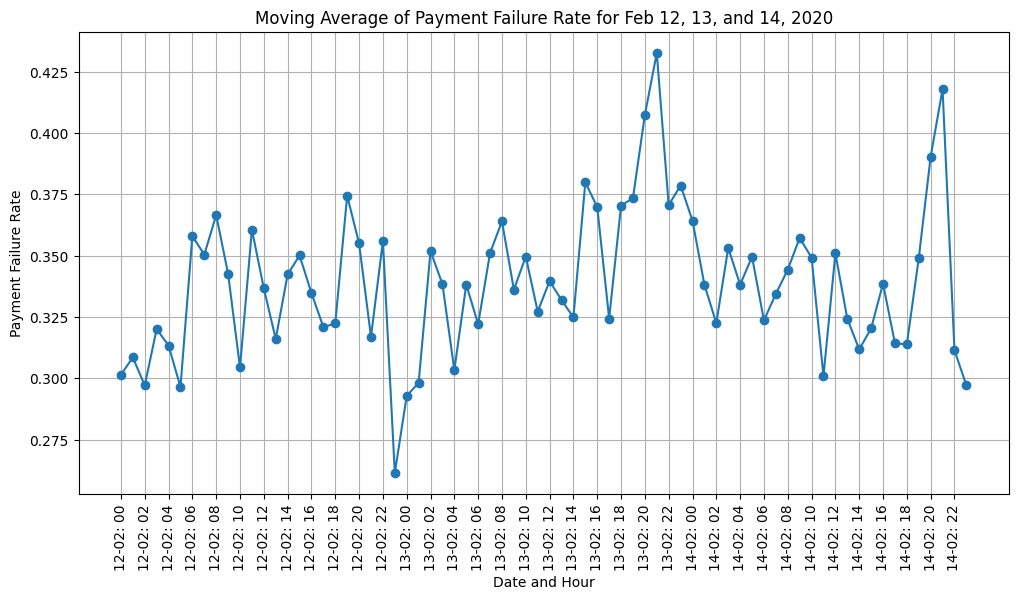

In [4]:
# Visualize the Moving Avg. of Payment Failure Rate
plt.figure(figsize=(12, 6))
plt.plot(data_grouped['date_hour'], data_grouped['failure_rate'], marker='o', linestyle='-')
plt.xticks(ticks=data_grouped['date_hour'][::2], rotation=90)  # Set the x-ticks to show every 2nd label
plt.xlabel('Date and Hour')
plt.ylabel('Payment Failure Rate')
plt.title('Moving Average of Payment Failure Rate for Feb 12, 13, and 14, 2020')
plt.grid(True)
plt.show()

### Plotting the Total Payment Failures by Date and Hour and highlighting the spike that led to the spike in customer complaints on 14 feb

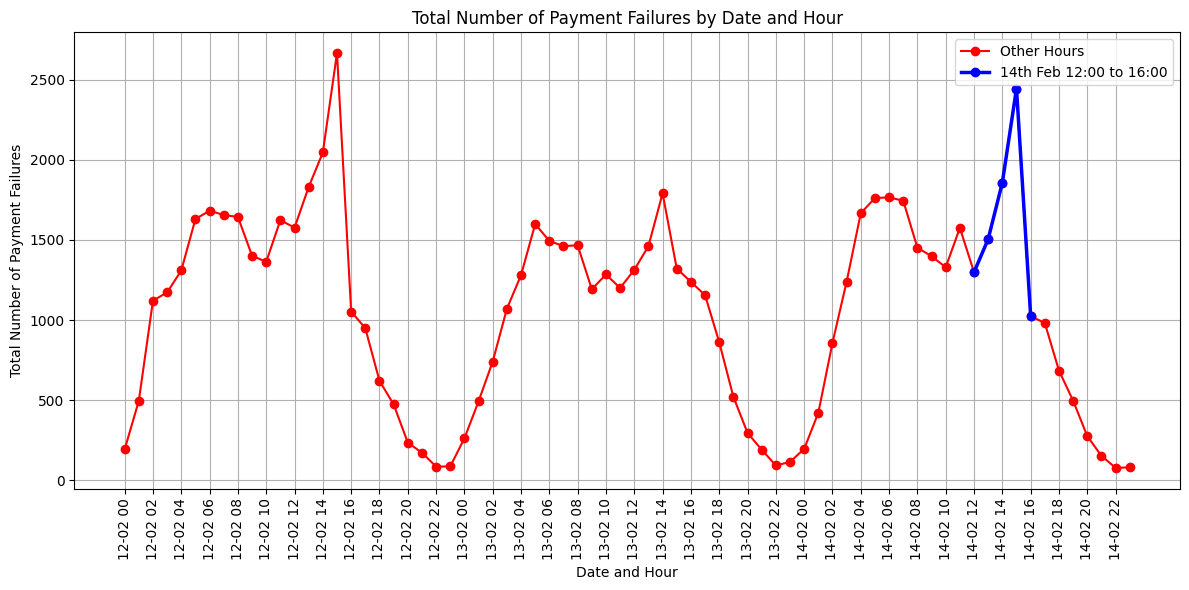

In [5]:
# Re-calculate the total number of payment failures per hour
data['failures'] = data['t'] - data['success']
hourly_failures = data.groupby('hr')['failures'].sum().reset_index()

plt.figure(figsize=(12, 6))

# Plotting the line for all hours
plt.plot(hourly_failures['hr'], hourly_failures['failures'], marker='o', color='red', label='Other Hours')

# Plotting the line for the highlighted period (14th Feb 12:00 to 16:00)
highlighted = hourly_failures[(hourly_failures['hr'] >= '2020-02-14 12:00:00') & (hourly_failures['hr'] <= '2020-02-14 16:00:00')]
plt.plot(highlighted['hr'], highlighted['failures'], marker='o', color='blue', label='14th Feb 12:00 to 16:00', linewidth=2.5)

# Add title and labels
plt.title('Total Number of Payment Failures by Date and Hour')
plt.xlabel('Date and Hour')
plt.ylabel('Total Number of Payment Failures')
plt.grid(True)

# Setting x-ticks
plt.xticks(ticks=hourly_failures['hr'][::2], labels=hourly_failures['hr'][::2].dt.strftime('%d-%m %H'), rotation=90)

# Show legend
plt.legend()

plt.tight_layout()
plt.show()

### Anomaly Analysis using Isolation Forest

In [6]:
# Filter the data for transactions occurring in the spike between 14th February at 12:00 & 15:00
# Commenting & Uncommenting out to find out failure rates across all time and specifically in the spike between 14th Feb 12:00 & 15:00
#filtered_data = data[(data['hr'] >= '2020-02-14 12:00:00') & (data['hr'] <= '2020-02-14 15:00:00')]
filtered_data = data

# Function to apply Isolation Forest and obtain the most impactful combinations
def apply_isolation_forest(data, columns):
    # Prepare data for Isolation Forest
    grouped_data = data.groupby(columns)['isFailed'].mean().reset_index()
    grouped_data['isFailed'] = grouped_data['isFailed'] * 100

    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination='auto', random_state=42)
    grouped_data['anomaly_score'] = iso_forest.fit_predict(grouped_data[['isFailed']])

    # Identify impactful combinations (outliers)
    impactful_combinations = grouped_data[grouped_data['anomaly_score'] == -1].sort_values(by='isFailed', ascending=False)
    return impactful_combinations

# Applying Isolation Forest for different combinations
single_columns_impact_filtered_results = {}
for col in ['pg', 'pmt', 'sub_type', 'bank']:
    single_columns_impact_filtered_results[col] = apply_isolation_forest(filtered_data, [col])

double_columns_impact_filtered_results = {}
for col1 in ['pg', 'pmt', 'sub_type']:
    for col2 in ['pmt', 'sub_type', 'bank']:
        if col1 != col2:
            double_columns_impact_filtered_results[(col1, col2)] = apply_isolation_forest(filtered_data, [col1, col2])

triple_columns_impact_filtered_results = {}
for col1 in ['pg', 'pmt']:
    for col2 in ['sub_type']:
        for col3 in ['bank']:
            if col1 != col2 and col2 != col3 and col1 != col3:
                triple_columns_impact_filtered_results[(col1, col2, col3)] = apply_isolation_forest(filtered_data, [col1, col2, col3])

quadruple_columns_impact_filtered_results = apply_isolation_forest(filtered_data, ['pg', 'pmt', 'sub_type', 'bank'])

### Printing the results obtained from the Isolation Forest ML model to identify the combination of features that led to the highest rate of payment failures.

In [7]:
# Displaying the results
print("Single Column Impact (Filtered):")
print(pd.concat(single_columns_impact_filtered_results.values(), ignore_index=True))

pd.DataFrame([single_columns_impact_filtered_results]).to_csv('single_columns_impact_filtered_results.csv')

print("\nDouble Column Impact (Filtered):")
print(pd.concat(double_columns_impact_filtered_results.values(), ignore_index=True))
pd.DataFrame([double_columns_impact_filtered_results]).to_csv('double_columns_impact_filtered_results.csv')

print("\nTriple Column Impact (Filtered):")
print(pd.concat(triple_columns_impact_filtered_results.values(), ignore_index=True))
pd.DataFrame([triple_columns_impact_filtered_results]).to_csv('triple_columns_impact_filtered_results.csv')

print("\nQuadruple Column Impact (Filtered):")
print(quadruple_columns_impact_filtered_results)
pd.DataFrame(quadruple_columns_impact_filtered_results).to_csv('quadruple_columns_impact_filtered_results.csv')

Single Column Impact (Filtered):
              pg    isFailed  anomaly_score  pmt sub_type  \
0      PAYTM_UPI  100.000000             -1  NaN      NaN   
1        PHONEPE   98.104265             -1  NaN      NaN   
2         PAYPAL   96.045198             -1  NaN      NaN   
3       PAYTM_V2   93.589744             -1  NaN      NaN   
4    AIRTELMONEY   75.000000             -1  NaN      NaN   
..           ...         ...            ...  ...      ...   
132          NaN   15.217391             -1  NaN      NaN   
133          NaN   14.285714             -1  NaN      NaN   
134          NaN   14.285714             -1  NaN      NaN   
135          NaN    9.523810             -1  NaN      NaN   
136          NaN    9.090909             -1  NaN      NaN   

                              bank  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
..          

### Analysis to identify the merchants most impacted by the payments failure spike on 14 Feb, and quantifying the impact.

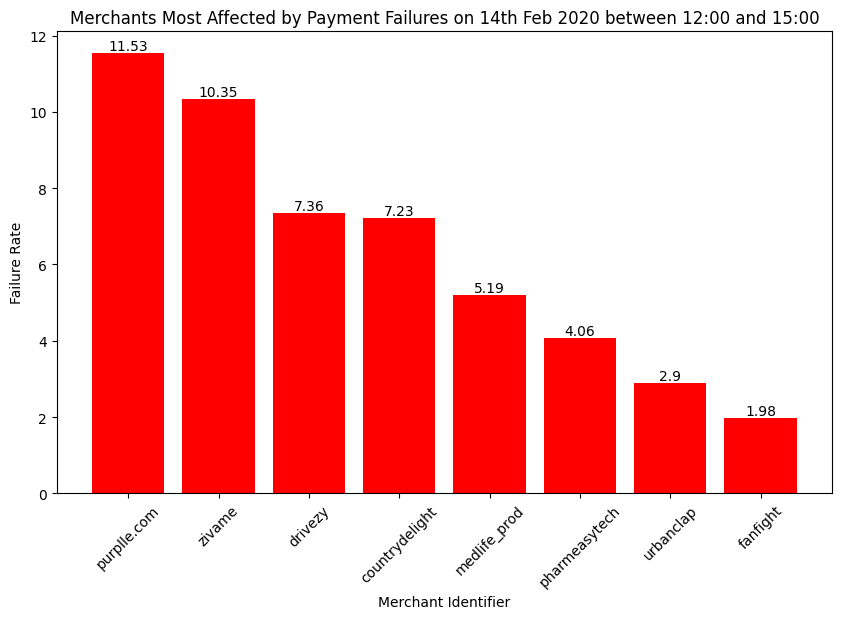

In [8]:
# Solution to Question Q 1.1.3

# Convert 'hr' to datetime to filter for 14th Feb
data['hr'] = pd.to_datetime(data['hr'], errors='coerce')

# Filter data for February 14th, 2020 spike, between 12:00 and 15:00 
feb_14_data = data[
    (data['hr'] >= pd.to_datetime('2020-02-14 12:00')) &
    (data['hr'] <= pd.to_datetime('2020-02-14 15:00'))
]

# Calculate total transactions and failures per merchant
merchant_failure_data = feb_14_data.groupby('mid').agg(
    total_transactions=('t', 'sum'),
    total_failures=('isFailed', 'sum')
).reset_index()

# Calculate failure rate per merchant
merchant_failure_data['failure_rate'] = merchant_failure_data['total_failures'] / merchant_failure_data['total_transactions']

# Filter out merchants with no transactions or zero failure rate
merchant_failure_data = merchant_failure_data[(merchant_failure_data['total_transactions'] > 0) & (merchant_failure_data['failure_rate'] > 0)]

# Sort data by failure rate in descending order
merchant_failure_data_sorted = merchant_failure_data.sort_values(by='failure_rate', ascending=False)

# Plotting the payment failure rates per merchant
plt.figure(figsize=(10, 6))
bars = plt.bar(merchant_failure_data_sorted['mid'], merchant_failure_data_sorted['failure_rate']*100, color='red')
plt.xticks(rotation=45)
plt.xlabel('Merchant Identifier')
plt.ylabel('Failure Rate')
plt.title('Merchants Most Affected by Payment Failures on 14th Feb 2020 between 12:00 and 15:00')

# Adding numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

### From the aggregation of payment failures rate, we observe that all the 8 merchants who used the platform on 14 feb were affected.
### However, when total number of payment failures are considered, we see that fanfight is disproportionately affected by the spike on 14 feb 2020

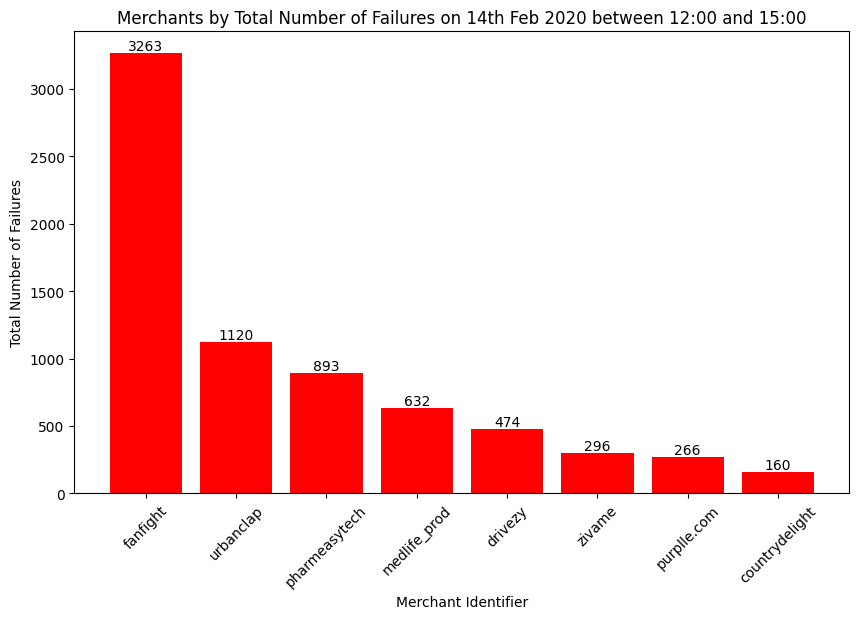

In [9]:
# Calculate the total number of failures for each merchant in the filtered time window
feb_14_data['total_failures'] = feb_14_data['t'] - feb_14_data['success']

# Group by merchant to calculate the total number of failures
merchant_failure_data_total = feb_14_data.groupby('mid')['total_failures'].sum().reset_index()

# Sort by total number of failures in descending order
merchant_failure_data_sorted = merchant_failure_data_total.sort_values(by='total_failures', ascending=False)

# Plot the Total Number of Failures per merchant
plt.figure(figsize=(10, 6))
bars = plt.bar(merchant_failure_data_sorted['mid'], merchant_failure_data_sorted['total_failures'], color='red')
plt.xticks(rotation=45)
plt.xlabel('Merchant Identifier')
plt.ylabel('Total Number of Failures')
plt.title('Merchants by Total Number of Failures on 14th Feb 2020 between 12:00 and 15:00')

# Add numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

plt.show()